# Hackaton evaluation metrics 

In this notebook we provide the functions that are used to calculate the quantitative evaluation metric for each magnification in the data set. The quantutative evaluation metric used to assess the hackathon contributions is divided into two parts: The images are compared using the mean absolute error (MAE) between generated and ground truth images using 1) features extracted by the CellProfiler and 2) pixel values. The evaluation suite in this notebook will be run on each magnification seperately and the final metric is given by the weighted average
\begin{equation*}
\mathrm{MAE}_\mathrm{tot} = \frac{1}{n_{tot} }\left( n_{20x}\mathrm{MAE}_{20X} +  n_{40x}\mathrm{MAE}_{40X} +  n_{60x}\mathrm{MAE}_{60X} \right)
\end{equation*}

where $n$ and $n_{20x}/n_{40x}/n_{60x}$ is the number of images in the total and $20x/40x/60x$ data set respectively. 



In [1]:
# DELETE THIS 
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
import sys
sys.path.append('../..')  # add `src` package location to sys.path
from src.settings import DATA_DIR

## Function Definitions

Below we give the functions that underlie the calculation of each metric. 

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import sys
import os
import glob
import re 

def get_cellprofiler_mean_absolute_error(targ_file, pred_file):
    """The relative mean absolute error between two data sets. 

    Parameters
    ----------
    targ_file : str
        Path to csv file containing the CellProfiler results for ground truth images
        
    pred_file : str
        Path to csv file containing the CellProfiler results for generated  images

    Returns
    ----------
    mae_per_feature : array
        Mean absolute error (mae) for each feature in the dataset. Each feature-mae is normalized 
        with the corresponding feature median to account for varying feature scales. 
    
    mae : float64
        Averaged mae_per_feature
    
    feature_names : object
        names of features in data set
        
    """
    
    # read the results into dataframes 
    df_targ = pd.read_csv(targ_file) 
    df_pred = pd.read_csv(pred_file)
    df_targ = df_targ.drop(['Metadata_Well', 'ImageNumber','Metadata_FoV'], axis=1) # drop metadata
    df_pred = df_pred.drop(['Metadata_Well', 'ImageNumber','Metadata_FoV'], axis=1) # drop metadata
    n_features = len(df_pred.columns) 
    feature_names = df_targ.keys()
    
    # feature normalization 
    median_targ = df_targ.median()
    df_targ =                                       df_targ/median_targ
    df_pred = (df_pred - np.arange(n_features)*median_targ)/median_targ
    #df_pred = (df_pred - median_targ)/median_targ # Prediction differs by one median for each feature (for testing)

    # mean absolute error for each normalized feature 
    mae_per_feature = mean_absolute_error(df_pred, df_targ, multioutput='raw_values')
    
    # Take weighted average of the mean absolute errors 
    # "mae" IS THE METRIC THAT WILL BE USED FOR ASSESSMENT 
    weights = np.ones(mae_per_feature.shape)
    mae = np.average(mae_per_feature, weights=weights)
    return mae, mae_per_feature, feature_names


def convert_images_to_array(image_dir):
    """Convert images in directory to numpy arrays 

    Parameters
    ----------
    image_dir : str
        Path to image directory. The directory must contain n image triplets 
        with the naming convention
        AssayPlate_Greiner_#655090_D02_T0001F007L01A01Z01C01.tif
        AssayPlate_Greiner_#655090_D02_T0001F007L01A01Z01C02.tif
        AssayPlate_Greiner_#655090_D02_T0001F007L01A01Z01C03.tif
        representing the three target channels for each well and field of view.

        
    Returns
    ----------
    y_c01 : array
        Array containing n C01 images. Shape: (n, image width, image height) 
    
    y_c02 : array
        Array containing n C02 images. Shape: (n, image width, image height) 
    
    y_c03 : array
        Array containing n C03 images. Shape: (n, image width, image height) 
        
    """
    # dataframe to store metadata for each file 
    df = pd.DataFrame(columns = ['path', 'pos', 'F', 'C', 'Z']) 
    df_row = pd.DataFrame(np.array([[0,0,0,0,0]]), columns = ['path', 'pos', 'F', 'C', 'Z']) 

    # get all files in image_dir
    for x in os.walk(image_dir):
        file_list = glob.glob(x[0] + '/AssayPlate*.tif')

    # get metadata from each file name and store in df
    for file in file_list:
        filename = os.path.split(file)[1]
        df_row['path'] = file
        df_row['pos'] = re.search(r'.\d\d_T',filename).group()[0:3]
        df_row['F'] = re.search(r'\dF\d\d\d',filename).group()[1:]
        df_row['C'] = re.search(r'\dC\d\d',filename).group()[1:]
        df_row['Z'] = re.search(r'\dZ\d\d',filename).group()[1:]
        df = df.append(df_row, sort=False)
    df = df.reset_index(drop=True)

    # group dataframe according to pos (well) and F (field of view)
    df_grouped = df.groupby(['pos','F'])

    # empty lists to store images for each flouresence channel
    y_c01 = []
    y_c02 = []
    y_c03 = []

    # for every group, load image from each channel  
    for state, frame in df_grouped:
        frame = frame.sort_values(by=['C','Z'])
        for row_index, row in frame.iterrows():
            if row['C'] == 'C01':
                im = plt.imread(row['path'])
                y_c01.append(im)
            elif row['C'] == 'C02':
                im = plt.imread(row['path'])
                y_c02.append(im)
            elif row['C'] == 'C03':
                im = plt.imread(row['path'])
                y_c03.append(im)

    # convert to numpy array
    y_c01 = np.array(y_c01)
    y_c02 = np.array(y_c02)
    y_c03 = np.array(y_c03)

    return y_c01, y_c02, y_c03

def get_pixelwise_mean_absolute_error(targ_dir, pred_dir):
    """Pixelwise mean absolute error between two image data sets
    
    Parameters
    ----------
    target_dir : str
        Path to image directory containing ground truth images.
    
    pred_dir : str
        Path to image directory containing generated images. T
        
    Both directories must contain n image triplets with the naming convention
    AssayPlate_Greiner_#655090_D02_T0001F007L01A01Z01C01.tif
    AssayPlate_Greiner_#655090_D02_T0001F007L01A01Z01C02.tif
    AssayPlate_Greiner_#655090_D02_T0001F007L01A01Z01C03.tif
    representing the three target channels for each well and field of view.

    Returns
    ----------
    mae_c01 : float64
        Pixel-to-pixel mean absolute error for channel C01 
    
    mae_c02 : float64
        Pixel-to-pixel mean absolute error for channel C02 
    
    mae_c03 : float64
        Pixel-to-pixel mean absolute error for channel C03
    
    mae : float64
        Mean of mae_c01, mae_c02 and mae_c03
    """
    # convert target images to array
    y_c01_targ, y_c02_targ, y_c03_targ = convert_images_to_array(targ_dir)
    # convert predicted images to array
    y_c01_pred, y_c02_pred, y_c03_pred = convert_images_to_array(pred_dir)
    
    # calculate mae between target and predicted images
    mae_c01 = mean_absolute_error(y_c01_targ.flatten(), y_c01_pred.flatten())
    mae_c02 = mean_absolute_error(y_c02_targ.flatten(), y_c02_pred.flatten())
    mae_c03 = mean_absolute_error(y_c03_targ.flatten(), y_c03_pred.flatten())
    
    # Take weighted average of the mean absolute errors 
    mae = np.average([mae_c01, mae_c02, mae_c03])
    
    return mae, mae_c01, mae_c02, mae_c03


## CellProfiler Mean Absolute Error 

We calculate the MAE based on the comparison of image features derived from CellProfiler. Since the image features have different scale the errors are normalized using each respective feature median.

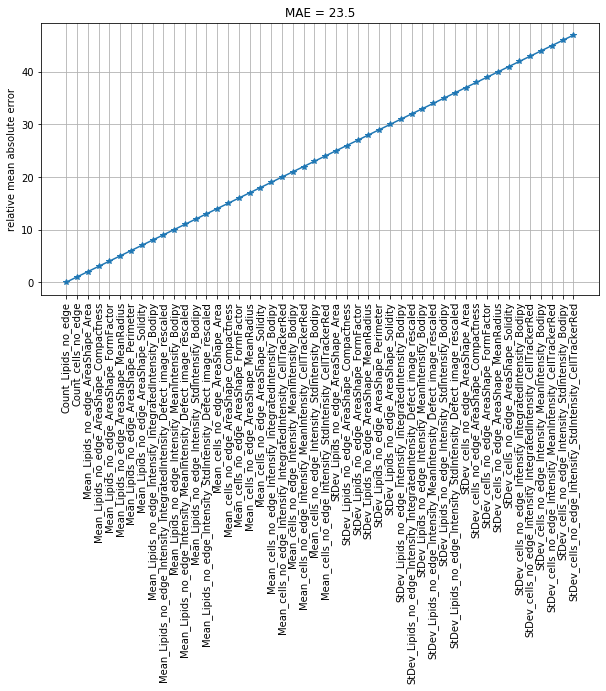

In [3]:
input_dir = 'temp/cp_pipeline_results'
targ_file = DATA_DIR.joinpath(input_dir).joinpath('60x_hack.csv') #results for ground truth
pred_file = DATA_DIR.joinpath(input_dir).joinpath('60x_hack.csv') #results for prediction 

#targ_file = "path to csv-file containing result for ground truth images"
#pred_file = "path to csv-file containing result for generated images"

mae_cp, mae_per_feature, feature_names = get_cellprofiler_mean_absolute_error(targ_file, pred_file)

# plot the mean absolute error per normalized feature
f, ax = plt.subplots(figsize = (10,5)) 
ax.set_title('MAE = ' + str(mae_cp) )
ax.set_ylabel('relative mean absolute error')
ax.plot(mae_per_feature, '-*')
ax.grid(True)
plt.xticks(np.arange(len(mae_per_feature)), feature_names, rotation=90)
plt.show()

## Pixelwise Mean Absolute Error 

We calculate the pixel-to-pixel MAE averaged over the three target channels.  

In [4]:
input_dir = 'interim'
targ_dir = DATA_DIR.joinpath(input_dir).joinpath('data60x/60x_hold_out') #results for ground truth
pred_dir = DATA_DIR.joinpath(input_dir).joinpath('data60x/60x_hold_out') #results for prediction 
#targ_dir = "path to directory containing ground truth images for all channels, one magnification"
#pred_dir = "path to directory containing generated images for all channels, one magnification"
mae_pix,_,_,_ = get_pixelwise_mean_absolute_error(targ_dir, pred_dir)


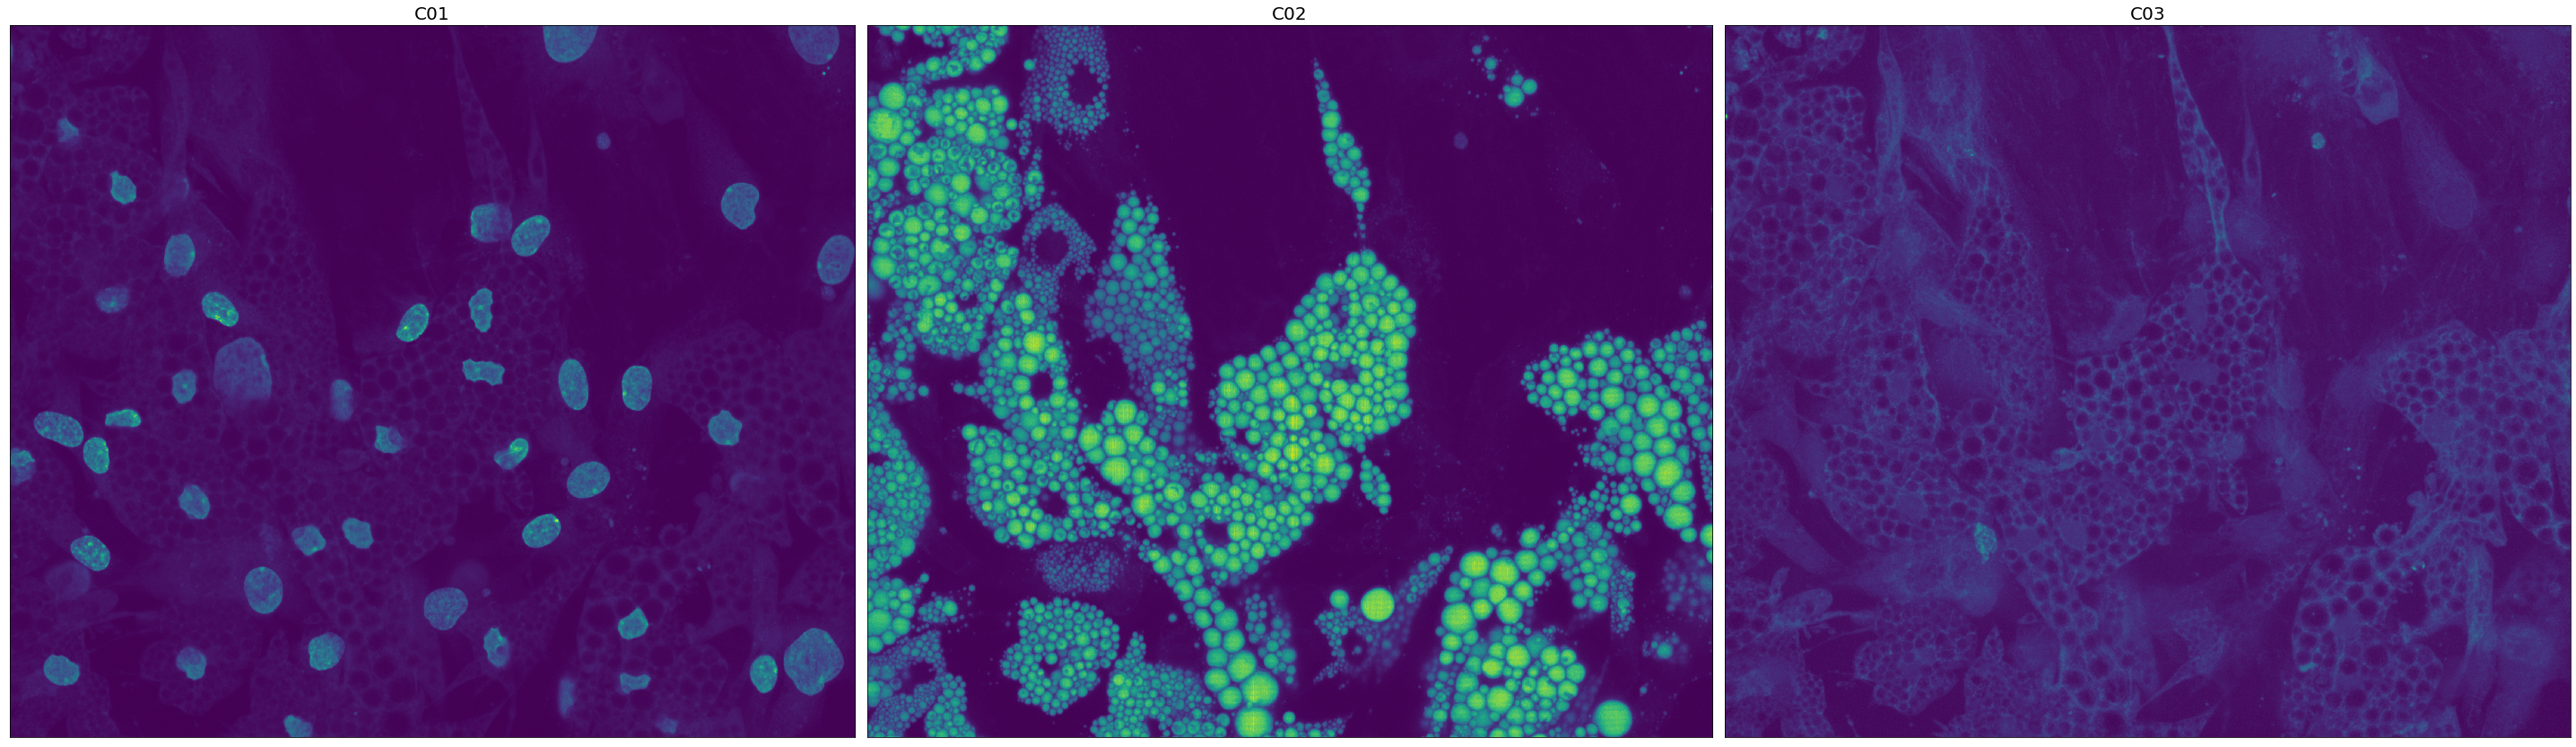

In [20]:
y_c01, y_c02, y_c03 = convert_images_to_array(targ_dir)

image_index = 0 # choose image

f, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize = (40,20)) 

ax[0].imshow( y_c01[image_index,:,:] )
ax[0].set_title('C01',size=20)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].imshow( y_c02[image_index,:,:] )
ax[1].set_title('C02',size=20)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

ax[2].imshow( y_c03[image_index,:,:] )
ax[2].set_title('C03',size=20)
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

plt.tight_layout()

## Final evaluation metric 

The end point metric is given by the average of the CellProfiler and pixel-to-pixel MAEs

In [6]:
mae = np.average([mae_cp, mae_pix])
print('Evaluation metric = ' + str(mae))

Evaluation metric = 11.75


In [7]:
import os
os.system('jupyter nbconvert --to html hackathon_evaluation_metrics.ipynb')

0